In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Read datasets

In [4]:
fake = pd.read_csv(r"C:\Users\Shreyasi  Saha\Downloads\Fake-News-Project\Fake News Project\Fake.csv")

In [5]:
true = pd.read_csv(r"C:\Users\Shreyasi  Saha\Downloads\Fake-News-Project\Fake News Project\True.csv")


In [6]:
fake.shape

(23481, 4)

In [7]:
true.shape

(21417, 4)

# Data cleaning and preparation

In [8]:
# Add target columns for fake and true
fake['target'] = 0
true['target'] = 1

In [9]:
# Concatenate dataframes
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(44898, 5)

In [10]:
# Shuffle the data
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [11]:
# check the data 

data.head()

title  \
0   REPORT: Five-Year-Old Girl Is Detained And Se...   
1  Factbox: Major U.S. Supreme Court abortion rig...   
2  Republicans join Democratic call for clarity o...   
3  BREAKING! Refugee Terrorist Coverup: Obama’s D...   
4  EU's Schulz says working with Trump will be 'h...   

                                                text       subject  \
0  Attorneys are racing to the defense of a child...          News   
1  (Reuters) - The U.S. Supreme Court’s key rulin...  politicsNews   
2  WASHINGTON (Reuters) - Two of President Donald...  politicsNews   
3  Federal lawmakers are investigating how a form...     left-news   
4  PARIS (Reuters) - The election of Donald Trump...  politicsNews   

                date  target  
0   January 28, 2017       0  
1     June 26, 2016        1  
2     March 6, 2017        1  
3        Mar 9, 2017       0  
4  November 9, 2016        1

In [12]:
# Removing the date (we are not using it for the analysis)
data.drop(["date"],axis=1,inplace=True)
data.head()

title  \
0   REPORT: Five-Year-Old Girl Is Detained And Se...   
1  Factbox: Major U.S. Supreme Court abortion rig...   
2  Republicans join Democratic call for clarity o...   
3  BREAKING! Refugee Terrorist Coverup: Obama’s D...   
4  EU's Schulz says working with Trump will be 'h...   

                                                text       subject  target  
0  Attorneys are racing to the defense of a child...          News       0  
1  (Reuters) - The U.S. Supreme Court’s key rulin...  politicsNews       1  
2  WASHINGTON (Reuters) - Two of President Donald...  politicsNews       1  
3  Federal lawmakers are investigating how a form...     left-news       0  
4  PARIS (Reuters) - The election of Donald Trump...  politicsNews       1

In [13]:
# Removing the title (we will only use the text)
data.drop(["title"],axis=1,inplace=True)
data.head()

text       subject  target
0  Attorneys are racing to the defense of a child...          News       0
1  (Reuters) - The U.S. Supreme Court’s key rulin...  politicsNews       1
2  WASHINGTON (Reuters) - Two of President Donald...  politicsNews       1
3  Federal lawmakers are investigating how a form...     left-news       0
4  PARIS (Reuters) - The election of Donald Trump...  politicsNews       1

In [14]:
# Convert to lowercase

data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

text       subject  target
0  attorneys are racing to the defense of a child...          News       0
1  (reuters) - the u.s. supreme court’s key rulin...  politicsNews       1
2  washington (reuters) - two of president donald...  politicsNews       1
3  federal lawmakers are investigating how a form...     left-news       0
4  paris (reuters) - the election of donald trump...  politicsNews       1

In [15]:
# Remove punctuation

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

In [16]:
# Check
data.head()

text       subject  target
0  attorneys are racing to the defense of a child...          News       0
1  reuters  the us supreme court’s key rulings on...  politicsNews       1
2  washington reuters  two of president donald tr...  politicsNews       1
3  federal lawmakers are investigating how a form...     left-news       0
4  paris reuters  the election of donald trump as...  politicsNews       1

In [18]:
# Removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to C:\Users\Shreyasi
[nltk_data]     Saha\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [19]:
data.head()

text       subject  target
0  attorneys racing defense child little girl det...          News       0
1  reuters us supreme court’s key rulings abortio...  politicsNews       1
2  washington reuters two president donald trump’...  politicsNews       1
3  federal lawmakers investigating former iraqi i...     left-news       0
4  paris reuters election donald trump united sta...  politicsNews       1

In [20]:
# checking null values

data.isnull().sum()

text       0
subject    0
target     0
dtype: int64

# EDA

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


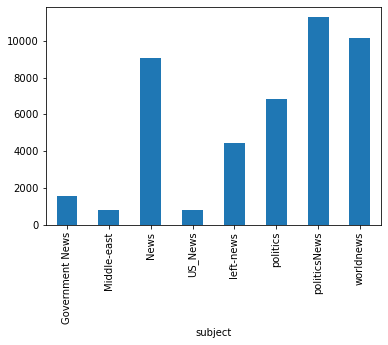

In [21]:
# How many articles per subject?
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

target
0    23481
1    21417
Name: text, dtype: int64


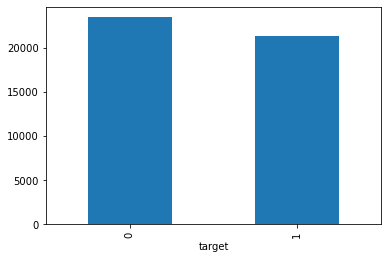

In [22]:
# How many fake and real articles?
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()

In [23]:
# Most frequent words counter (Code adapted from https://www.kaggle.com/rodolfoluna/fake-news-detector)   
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

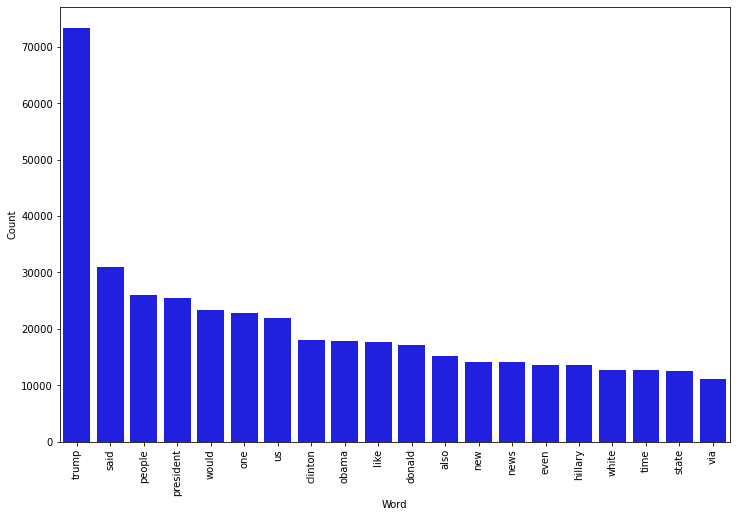

In [24]:
# Most frequent words in fake news
counter(data[data["target"] == 0], "text", 20)

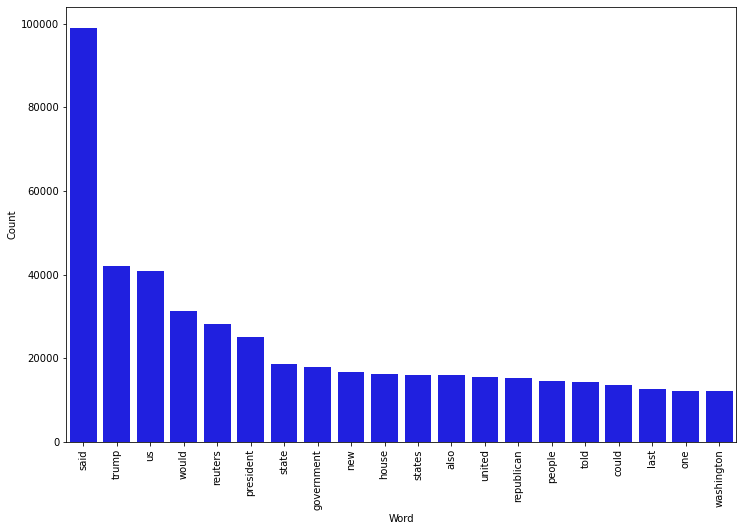

In [25]:
# Most frequent words in real news
counter(data[data["target"] == 1], "text", 20)

# Model building

In [26]:
# Function to plot the confusion matrix (code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Peparing the data


In [27]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

# Naive Bayes

In [28]:
dct = dict()

from sklearn.naive_bayes import MultinomialNB

NB_classifier = MultinomialNB()
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', NB_classifier)])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

dct['Naive Bayes'] = round(accuracy_score(y_test, prediction)*100,2)


accuracy: 95.53%


Confusion matrix, without normalization


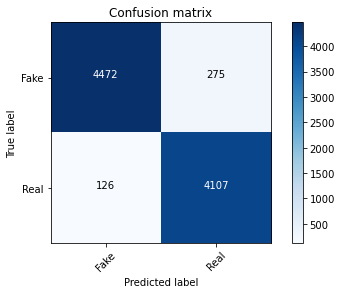

In [29]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# Logistic regression

In [30]:
# Logistic regression
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Logistic Regression'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 98.98%


Confusion matrix, without normalization


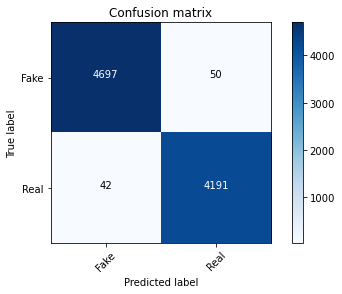

In [31]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# Decision Tree

In [32]:
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Decision Tree'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 99.58%


Confusion matrix, without normalization


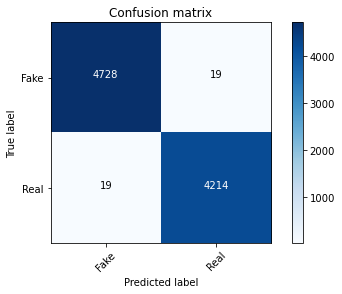

In [33]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# Random Forest


In [34]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Random Forest'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 99.06%


Confusion matrix, without normalization


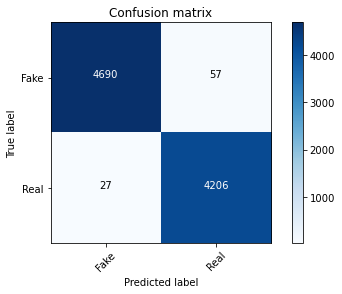

In [35]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# Comparing Different Models

([<matplotlib.axis.YTick at 0x196eae89040>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

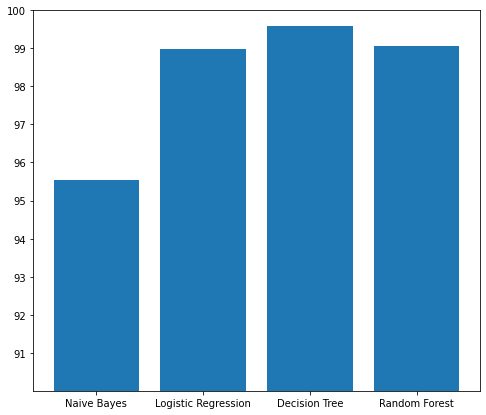

In [36]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,7))
plt.bar(list(dct.keys()),list(dct.values()))
plt.ylim(90,100)
plt.yticks((91, 92, 93, 94, 95, 96, 97, 98, 99, 100))

([<matplotlib.axis.YTick at 0x1968156a730>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

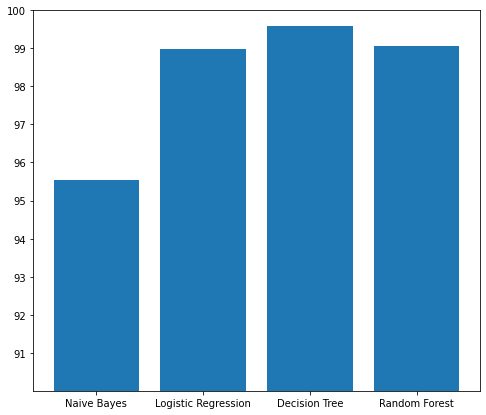

In [37]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,7))
plt.bar(list(dct.keys()),list(dct.values()))
plt.ylim(90,100)
plt.yticks((91, 92, 93, 94, 95, 96, 97, 98, 99, 100))

# conclusion :

we have applied many algorithm like (Naive Bayes , Logistic Regression,Decision Tree ,Random Forest ). but as we can see that Decision Tree has given the best accuracy score  